## **Lifelines classifier:**
> Floris Menninga \
> Datum: 3-03-2025 \
> Versie: 1



In [23]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns



In [24]:
lifelines_df = pd.read_csv("/home/floris/Documenten/Github/Lifelines_Classifier/data/Lifelines_Public_Health_dataset_2024.csv")
lifelines_df.index += 1

lifelines_df.head()

,GENDER,BIRTHYEAR,AGE_T1,AGE_T2,AGE_T3,ZIP_CODE,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,...,NSES_YEAR,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2,NEIGHBOURHOOD5_T2,NEIGHBOURHOOD6_T2,MENTAL_DISORDER_T1,MENTAL_DISORDER_T2
1,2,1960,52,55,59,9903,21.9,70.0,91.0,178.5,...,2010,-0.148238,8.0,1.0,3.0,5.0,3.0,4.0,0.0,0.0
2,2,1964,48,51,57,8411,20.9,62.0,93.0,172.5,...,2010,0.357413,10.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0
3,2,1951,58,62,68,9101,24.6,71.0,104.0,170.0,...,2010,-1.730366,9.0,1.0,2.0,2.0,3.0,4.0,0.0,0.0
4,1,1958,54,57,61,9761,25.0,70.5,95.0,169.5,...,2010,0.106612,8.0,2.0,1.0,1.0,5.0,5.0,0.0,0.0
5,2,1963,45,50,57,9201,24.0,61.0,95.0,159.8,...,2006,-1.004381,9.0,4.0,1.0,1.0,5.0,5.0,0.0,0.0


In [25]:
lifelines_df["GENDER"] = lifelines_df["GENDER"].map({2: "F", 1: "M"})
lifelines_df.head()

,GENDER,BIRTHYEAR,AGE_T1,AGE_T2,AGE_T3,ZIP_CODE,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,...,NSES_YEAR,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2,NEIGHBOURHOOD5_T2,NEIGHBOURHOOD6_T2,MENTAL_DISORDER_T1,MENTAL_DISORDER_T2
1,F,1960,52,55,59,9903,21.9,70.0,91.0,178.5,...,2010,-0.148238,8.0,1.0,3.0,5.0,3.0,4.0,0.0,0.0
2,F,1964,48,51,57,8411,20.9,62.0,93.0,172.5,...,2010,0.357413,10.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0
3,F,1951,58,62,68,9101,24.6,71.0,104.0,170.0,...,2010,-1.730366,9.0,1.0,2.0,2.0,3.0,4.0,0.0,0.0
4,M,1958,54,57,61,9761,25.0,70.5,95.0,169.5,...,2010,0.106612,8.0,2.0,1.0,1.0,5.0,5.0,0.0,0.0
5,F,1963,45,50,57,9201,24.0,61.0,95.0,159.8,...,2006,-1.004381,9.0,4.0,1.0,1.0,5.0,5.0,0.0,0.0


De "1" en "2" zijn vervangen door F voor vrouw en M voor man. 


In [34]:
codebook = {
    "attribute": lifelines_df.columns.tolist(), # Gebruik de kolom namen van het df voor de namen hier. 
    "unit": ["", "", "Jaar", "Jaar", "Jaar", "kg/m2", "kg", "cm", "cm", "cm", "kg/m2", "kg", "cm", "cm", "cm", "kg", "cm", "cm", "cm", "", "", "", "", "", "", "", "mmHg", "mmHg", "BPM", "BPM", "", "", "mmHg", "mmHg", "", "mmol/L", "mmol/L", "mmol/L", "mmol/L", "", "", "", "", "", "", "", "", "gram/day", "kcal/dag", "minuten", "", "minuten", "", "%","", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "Jaar ", "", "", "","", "", "score","score", "score", "score",],
    "dtype": lifelines_df.dtypes.tolist(), # Datatypes hier.
}

pd.DataFrame(codebook).set_index("attribute")

,unit,dtype
attribute,,
GENDER,,object
BIRTHYEAR,,int64
AGE_T1,Jaar,int64
AGE_T2,Jaar,int64
AGE_T3,Jaar,int64
...,...,...
NEIGHBOURHOOD4_T2,,float64
NEIGHBOURHOOD5_T2,score,float64
NEIGHBOURHOOD6_T2,score,float64


De "unit" kolommen zijn met de hand ingevuld. \
Optimalisatie: float64 en int64 vervangen door int8, de nummers blijven er toch ver onder. (To-do)

In [27]:
pd.DataFrame({
    "isna": lifelines_df.isna().sum()
})

,isna
GENDER,0
BIRTHYEAR,0
AGE_T1,0
AGE_T2,0
AGE_T3,0
...,...
NEIGHBOURHOOD4_T2,4886
NEIGHBOURHOOD5_T2,4887
NEIGHBOURHOOD6_T2,4884
MENTAL_DISORDER_T1,376


Geen NA's te bekennen.


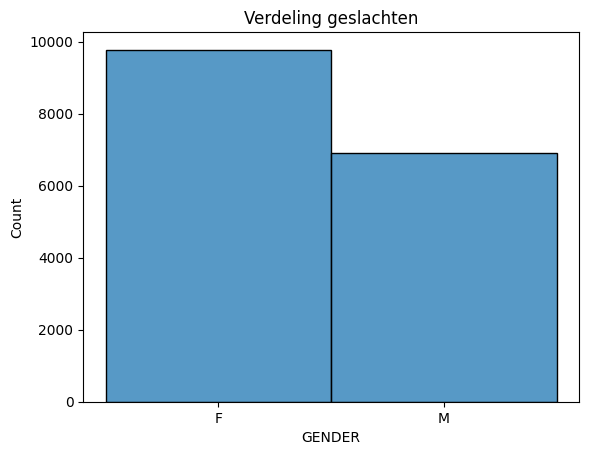

In [28]:
axs = sns.histplot(lifelines_df["GENDER"])
axs.set_title("Verdeling geslachten");


Ongelijke verdeling van Man/Vrouw datapunten. Meer vrouwen dan mannen. 


In [29]:
lifelines_df.describe()

,BIRTHYEAR,AGE_T1,AGE_T2,AGE_T3,ZIP_CODE,BMI_T1,WEIGHT_T1,HIP_T1,HEIGHT_T1,WAIST_T1,...,NSES_YEAR,NSES,NEIGHBOURHOOD1_T2,NEIGHBOURHOOD2_T2,NEIGHBOURHOOD3_T2,NEIGHBOURHOOD4_T2,NEIGHBOURHOOD5_T2,NEIGHBOURHOOD6_T2,MENTAL_DISORDER_T1,MENTAL_DISORDER_T2
count,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,16696.000000,...,16696.000000,16200.000000,11747.000000,11806.000000,11812.000000,11810.000000,11809.000000,11812.000000,16320.000000,13472.000000
mean,1963.883265,46.621766,50.386859,56.395604,9088.022221,25.948491,79.580642,99.176186,174.920394,90.150557,...,2009.363201,-0.576549,8.218609,1.942317,1.451490,1.755631,3.689813,4.075855,0.079534,0.085065
std,11.159835,11.179438,11.128222,11.160991,703.594702,4.110023,14.718271,9.177001,9.352034,11.800292,...,1.463493,1.079084,1.460666,0.821344,0.680361,1.038783,1.016746,0.810044,0.320736,0.333972
min,1927.000000,18.000000,20.000000,25.000000,1015.000000,15.400000,42.000000,62.000000,137.000000,60.000000,...,2006.000000,-7.121883,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1957.000000,40.000000,43.000000,49.000000,8496.500000,23.200000,69.000000,93.000000,168.000000,82.000000,...,2010.000000,-1.194383,8.000000,1.000000,1.000000,1.000000,3.000000,4.000000,0.000000,0.000000
50%,1964.000000,47.000000,51.000000,57.000000,9281.000000,25.400000,78.000000,98.000000,174.000000,90.000000,...,2010.000000,-0.580492,8.000000,2.000000,1.000000,1.000000,4.000000,4.000000,0.000000,0.000000
75%,1971.000000,54.000000,57.000000,64.000000,9654.000000,28.000000,89.000000,104.000000,181.500000,98.000000,...,2010.000000,0.183076,9.000000,2.000000,2.000000,2.000000,4.000000,5.000000,0.000000,0.000000
max,1995.000000,84.000000,88.000000,95.000000,9998.000000,53.800000,158.000000,185.000000,207.000000,156.000000,...,2010.000000,2.933054,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000


In [30]:
def by_unit(*units):
    # Retourneert een lijst van attributen die gevraagde eenheden hebben
    return [attribute for attribute, unit in zip(codebook["attribute"], codebook["unit"]) if unit in units]

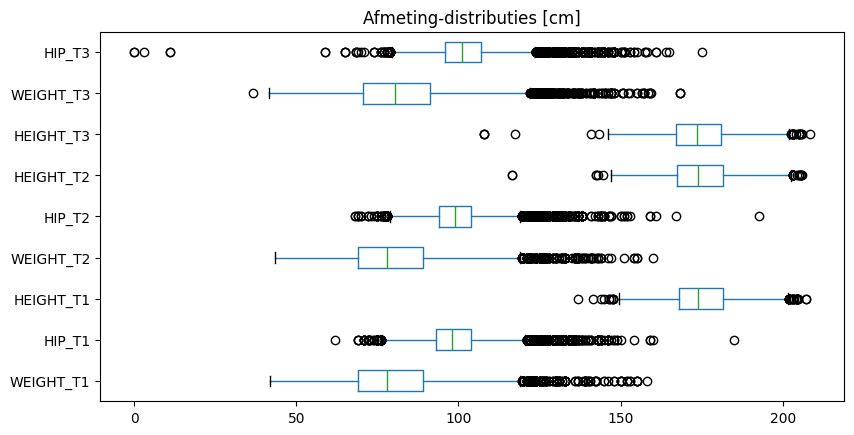

In [31]:
axs = lifelines_df[by_unit("cm")].boxplot(grid=False, vert=False, figsize=(9.6, 4.8))
axs.set_title("Afmeting-distributies [cm]");

Er zijn een groot aantal uitschieters.

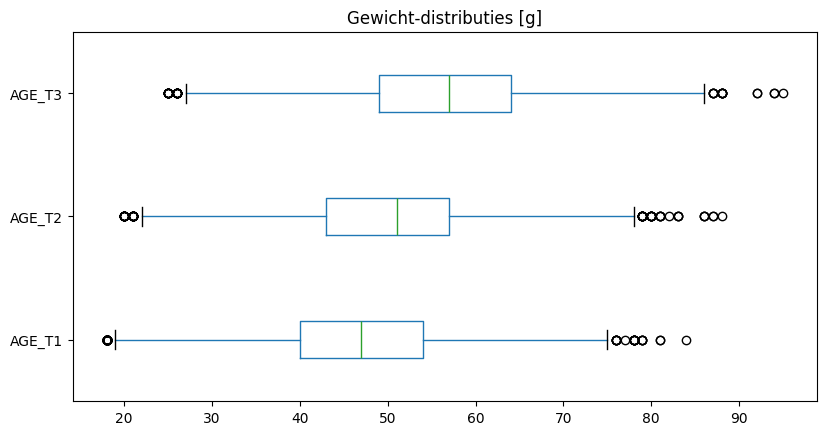

In [35]:
axs = lifelines_df[by_unit("Jaar")].boxplot(grid=False, vert=False, figsize=(9.6, 4.8))
axs.set_title("Gewicht-distributies [g]");

Tussen de verschillende meetpunten (T1 t/m T3) liggen de leeftijden steeds wat hoger, zoals verwachts. 

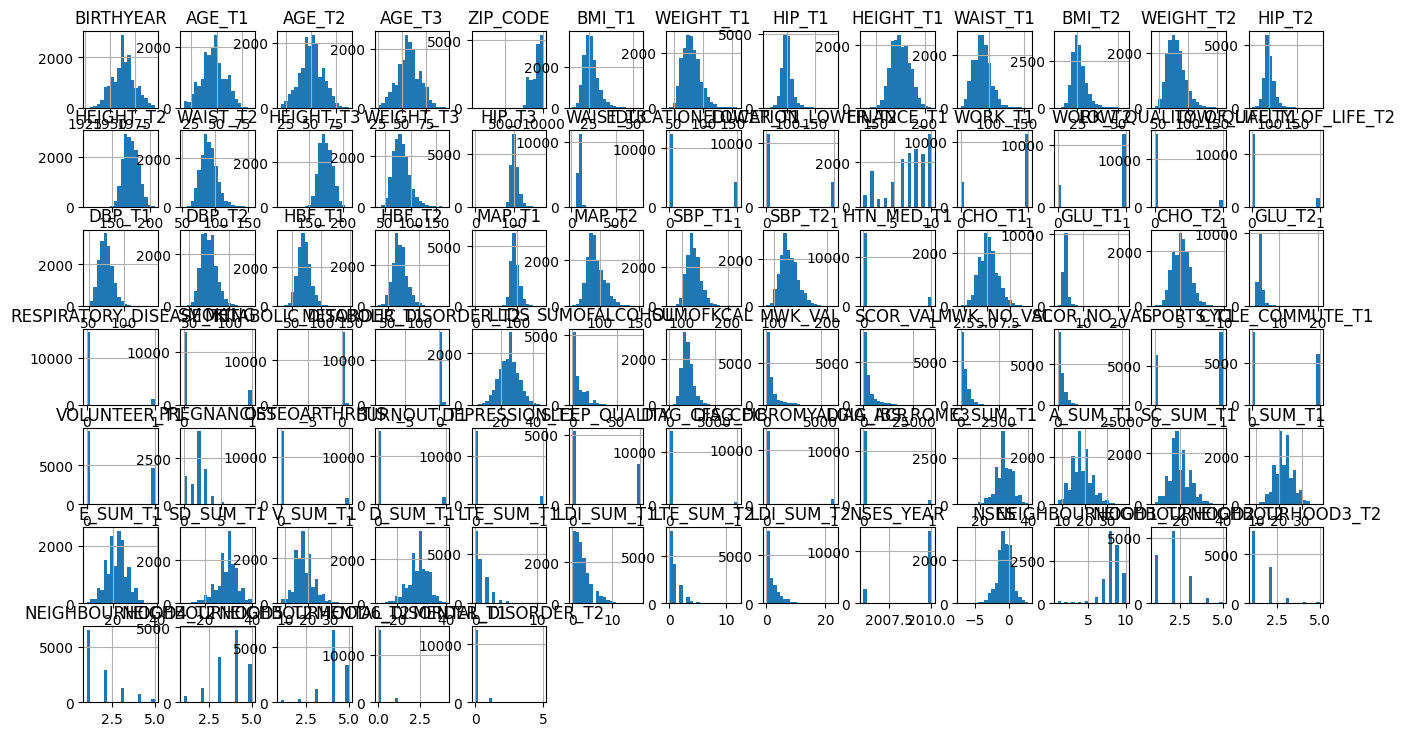

In [42]:
lifelines_df.hist(bins=20, layout=(8, 13), figsize=(16.0, 10));

To-do: overzichtelijker maken....

